<div class="alert alert-info">
<h1>Tree-Based Models </h1>
<h4>Environmental Statistics 10 </h4>
<h4>I.E. Azuh/C.F. Dormann </h4>
</div>

Tree-based models are powerful machine learning techniques for predictive modeling and decision-making. In this session, we'll explore the principles of tree-based modeling and its applications in various domains. Participants will learn how to build, interpret, and evaluate decision trees and ensemble methods like random forests and gradient boosting, unlocking the potential for accurate and robust predictive modeling.

There is two thing to learn today: 

  * How a classification/regression tree works.
  * How to combine many of such trees (by bagging or boosting).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RepeatedStratifiedKFold,cross_val_score
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier
import xgboost as xgb #XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.api as sm
from pygam import LinearGAM, s
import graphviz
import warnings
warnings.filterwarnings("ignore")


#conda install -c anaconda graphviz python-graphviz
#conda install -c conda-forge py-xgboost

## 1 Exercise 1: Using a CART/DecisionTree
A classification and regression tree, tree for short, can be efficiently fitted in Python using **sklearn.tree**'s `DecisionTreeRegressor`. 

### 1.1 Fit and prune
Fit the tree to **faraway**'s `mammalsleep` data, using `sleep` as response, all others as predictor.
Make the tree as long as possible, down to the leaf.

In [2]:
mammalsleep = pd.read_csv('mammalsleep.csv')
mammalsleep = mammalsleep.dropna()
mammalsleep.head()


,body,brain,nondream,dream,sleep,lifespan,gestation,predation,exposure,danger
1,1.000,6.6,6.3,2.0,8.3,4.5,42.0,3,1,3
4,2547.000,4603.0,2.1,1.8,3.9,69.0,624.0,3,5,4
5,10.550,179.5,9.1,0.7,9.8,27.0,180.0,4,4,4
6,0.023,0.3,15.8,3.9,19.7,19.0,35.0,1,1,1
7,160.000,169.0,5.2,1.0,6.2,30.4,392.0,4,5,4


In [3]:
X = mammalsleep.drop("sleep", axis=1)
y = mammalsleep["sleep"]

flong = DecisionTreeRegressor(min_samples_split=2, min_samples_leaf=1, ccp_alpha=0).fit(X, y) 

# Print textual representation of the trained trees
tree_text = tree.export_text(flong, feature_names=list(X.columns))
print(tree_text)

|--- nondream <= 10.20
|   |--- nondream <= 5.90
|   |   |--- nondream <= 4.00
|   |   |   |--- dream <= 0.75
|   |   |   |   |--- gestation <= 216.00
|   |   |   |   |   |--- value: [3.80]
|   |   |   |   |--- gestation >  216.00
|   |   |   |   |   |--- value: [3.90]
|   |   |   |--- dream >  0.75
|   |   |   |   |--- gestation <= 480.00
|   |   |   |   |   |--- value: [2.90]
|   |   |   |   |--- gestation >  480.00
|   |   |   |   |   |--- value: [3.90]
|   |   |--- nondream >  4.00
|   |   |   |--- dream <= 0.70
|   |   |   |   |--- value: [5.40]
|   |   |   |--- dream >  0.70
|   |   |   |   |--- nondream <= 5.45
|   |   |   |   |   |--- value: [6.20]
|   |   |   |   |--- nondream >  5.45
|   |   |   |   |   |--- value: [6.60]
|   |--- nondream >  5.90
|   |   |--- nondream <= 8.85
|   |   |   |--- dream <= 2.25
|   |   |   |   |--- nondream <= 7.60
|   |   |   |   |   |--- nondream <= 6.20
|   |   |   |   |   |   |--- value: [8.00]
|   |   |   |   |   |--- nondream >  6.20
|   | 

Now use cross-validation and adjustment of the complexity parameter to "prune" the tree back to a level supported by the data. The relevant column in the `printcp`-output is `xerror`, i.e "cross-validation error", which should be minimal (or, equivalently, `rel error`).

In [4]:
flong.cost_complexity_pruning_path(X, y)["ccp_alphas"]

array([0.00000000e+00, 2.03012210e-15, 8.92857143e-05, 1.19047619e-04,
       1.19047619e-04, 1.19047619e-04, 1.58730159e-04, 4.76190476e-04,
       4.76190476e-04, 5.83333333e-04, 1.07142857e-03, 2.29365079e-03,
       2.53968254e-03, 2.97619048e-03, 2.97619048e-03, 3.21428571e-03,
       3.80952381e-03, 4.80158730e-03, 6.70634921e-03, 8.63492063e-03,
       9.64285714e-03, 1.14682540e-02, 1.33928571e-02, 1.52380952e-02,
       1.71428571e-02, 2.48888889e-02, 5.33968254e-02, 5.93783069e-02,
       9.21904762e-02, 9.90634921e-02, 1.58933532e-01, 2.59102041e-01,
       3.14880952e-01, 2.23492441e+00, 2.96208997e+00, 1.52749215e+01])

In [5]:
np.random.seed(100) #1000

ccp_alphas = flong.cost_complexity_pruning_path(X, y)["ccp_alphas"]

flong = DecisionTreeRegressor(min_samples_split=2, min_samples_leaf=1).fit(X, y)

cp_values = []
xerror_values = []


for alpha in ccp_alphas:
    scores = cross_val_score(flong, X, y, cv=5)
    
    # Calculate the statistics
    n_nodes = np.unique(flong.apply(X)).shape[0]
    rel_error = 1 - scores.mean()
    xerror = rel_error
    cp = alpha
    
    cp_values.append(cp)
    xerror_values.append(xerror)


data = {'cp_values': cp_values, 'xerror_values': xerror_values}
df_flong = pd.DataFrame(data)
df_flong.head()


,cp_values,xerror_values
0,0.000000,0.113812
1,0.000089,0.096267
2,0.000119,0.088590
3,0.000119,0.109797
4,0.000119,0.125911


In [6]:
# Find the row with the minimum xerror_values
min_xerror_row = df_flong.loc[df_flong['xerror_values'].idxmin()]

# Extract the corresponding cp_values
min_cp_value = min_xerror_row['cp_values']

print(f"Minimum xerror_values: {min_xerror_row['xerror_values']}")
print(f"Corresponding cp_values: {min_cp_value}")

Minimum xerror_values: 0.07671784575917917
Corresponding cp_values: 0.2591020408162998


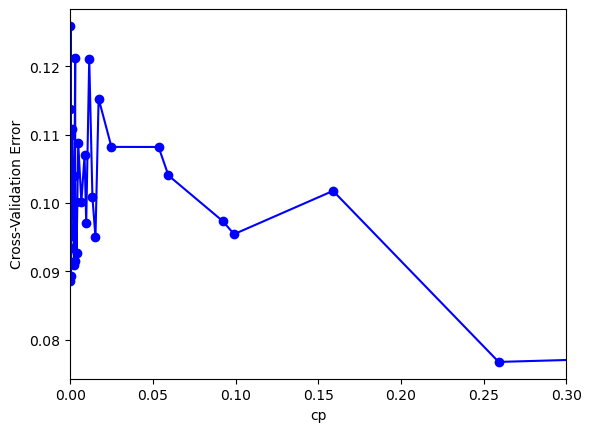

In [7]:
plt.plot(df_flong['cp_values'], df_flong['xerror_values'], marker='o', linestyle='-', color='b')
plt.xlim(0, 0.3)
plt.xlabel("cp")
plt.ylabel("Cross-Validation Error")
plt.show()

Now prune back:

In [8]:
# with prune
cp = 0.259
fcut = DecisionTreeRegressor(min_samples_split=2, min_samples_leaf=1, ccp_alpha=cp)
fcut.fit(X, y)

# Print textual representation of the trained trees
tree_text = tree.export_text(fcut, feature_names=list(X.columns))
print(tree_text)

|--- nondream <= 10.20
|   |--- nondream <= 5.90
|   |   |--- nondream <= 4.00
|   |   |   |--- value: [3.66]
|   |   |--- nondream >  4.00
|   |   |   |--- value: [5.96]
|   |--- nondream >  5.90
|   |   |--- value: [9.31]
|--- nondream >  10.20
|   |--- nondream <= 12.35
|   |   |--- value: [13.49]
|   |--- nondream >  12.35
|   |   |--- exposure <= 1.50
|   |   |   |--- value: [19.16]
|   |   |--- exposure >  1.50
|   |   |   |--- value: [16.40]



### 1.1 Plot
First plot the complex, then the pruned version. If possible, add number of cases in each group to the label.

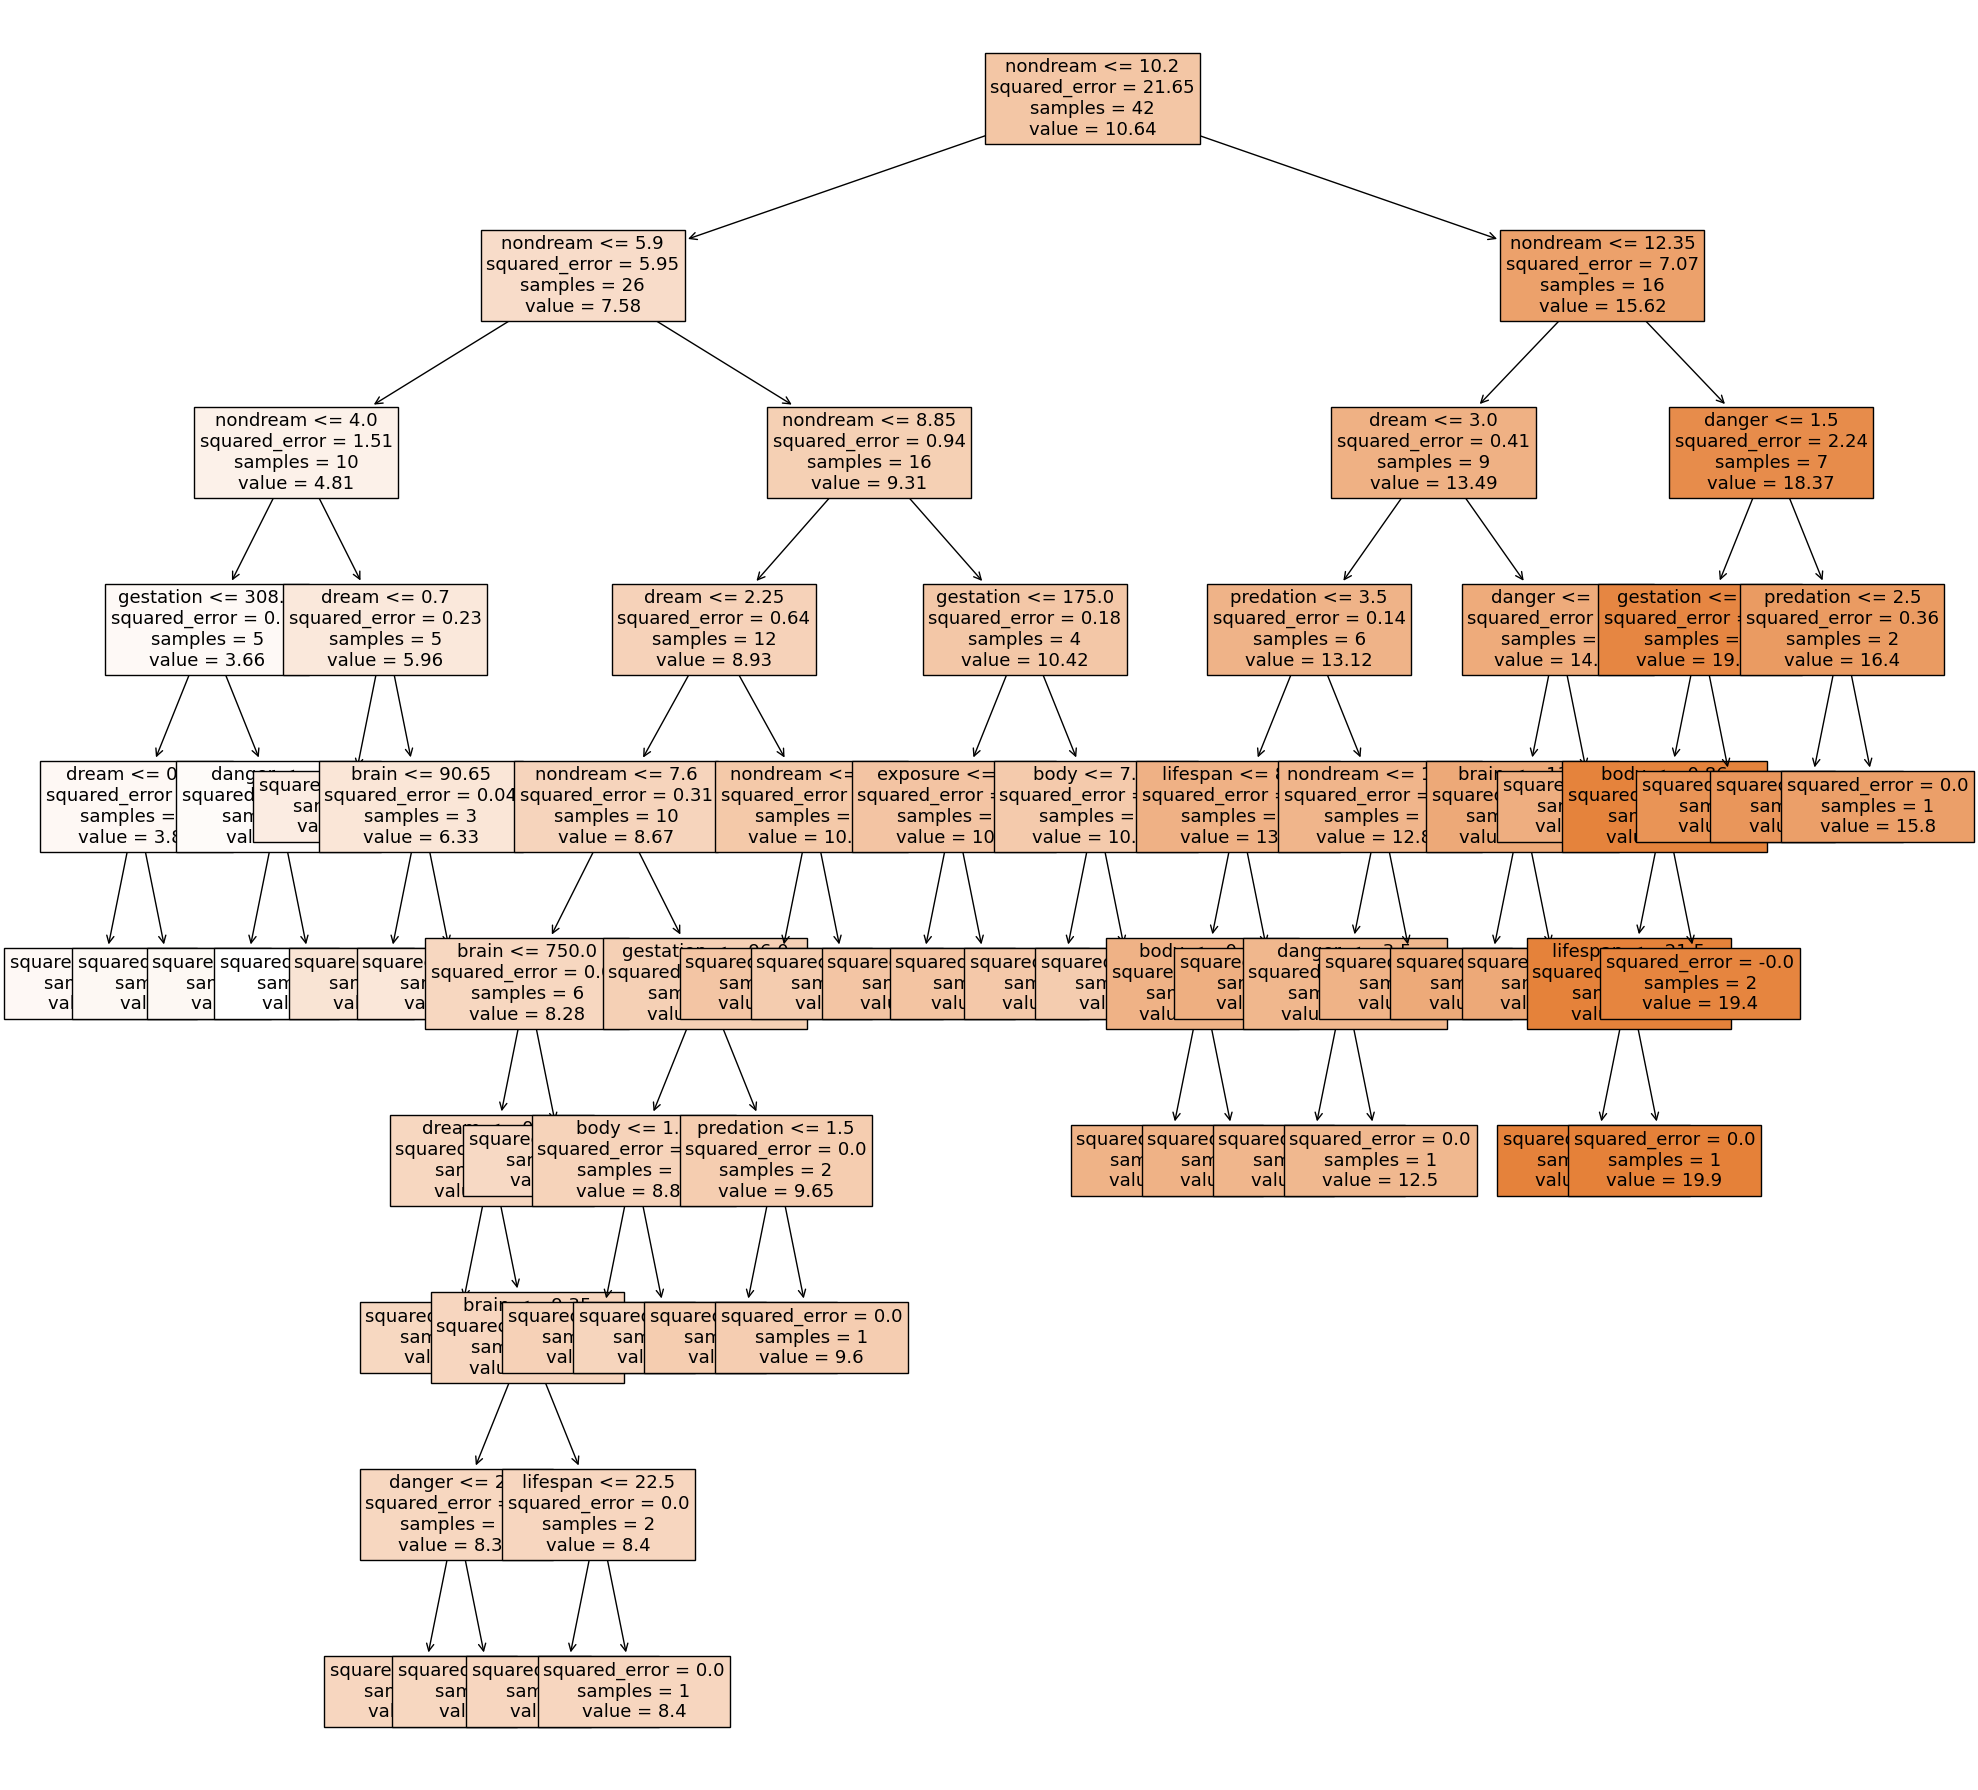

In [9]:
# Tree without prune
fig, ax = plt.subplots(figsize=(20, 18))
plot_tree(flong, filled=True, feature_names=list(X.columns), fontsize=13, precision=2, ax=ax)
plt.tight_layout()
plt.show()


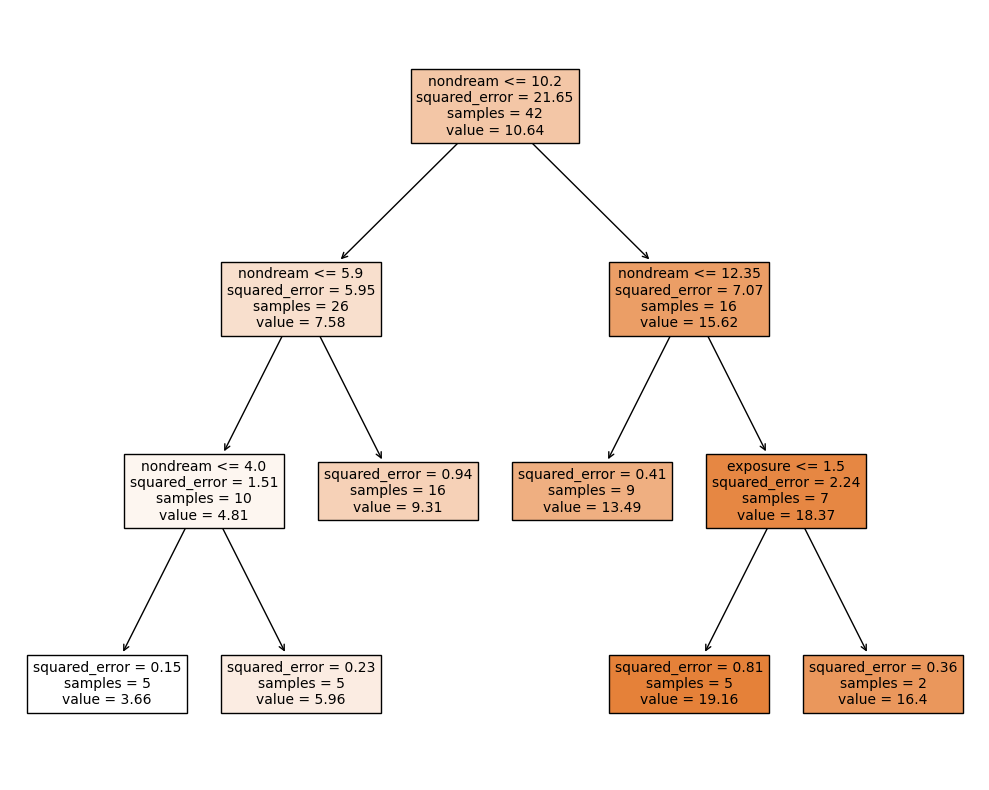

In [10]:
# Tree with prune
fig, ax = plt.subplots(figsize=(10, 8))
plot_tree(fcut, filled=True, feature_names=list(X.columns), fontsize=10, precision=2, ax=ax)
plt.tight_layout()
plt.show()


### BONUS: Using GridSearchCV

In [11]:
# Define features and target variable
X = mammalsleep.drop(columns=['sleep'])
y = mammalsleep['sleep']

# Set up parameter grid
param_grid = {
    'ccp_alpha': [0.0, 0.01, 0.1, 0.5, 1.0],  # Vary the complexity parameter (cp)
    'max_depth': [1, 3, 5, None],
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 6)

}

# Create the model
model = DecisionTreeRegressor(random_state=100)

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2') #['neg_mean_squared_error', 'r2']
grid_search.fit(X, y)

# Get the best parameters and the corresponding mean test scores
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

# Print best parameters and corresponding score
print("Best Parameters:", best_params)
#print("Best RMSE:", best_score)


Best Parameters: {'ccp_alpha': 0.1, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}


In [12]:
f_bonus = DecisionTreeRegressor(min_samples_split=2, min_samples_leaf=3, ccp_alpha=0.1, max_depth=3 ).fit(X, y)

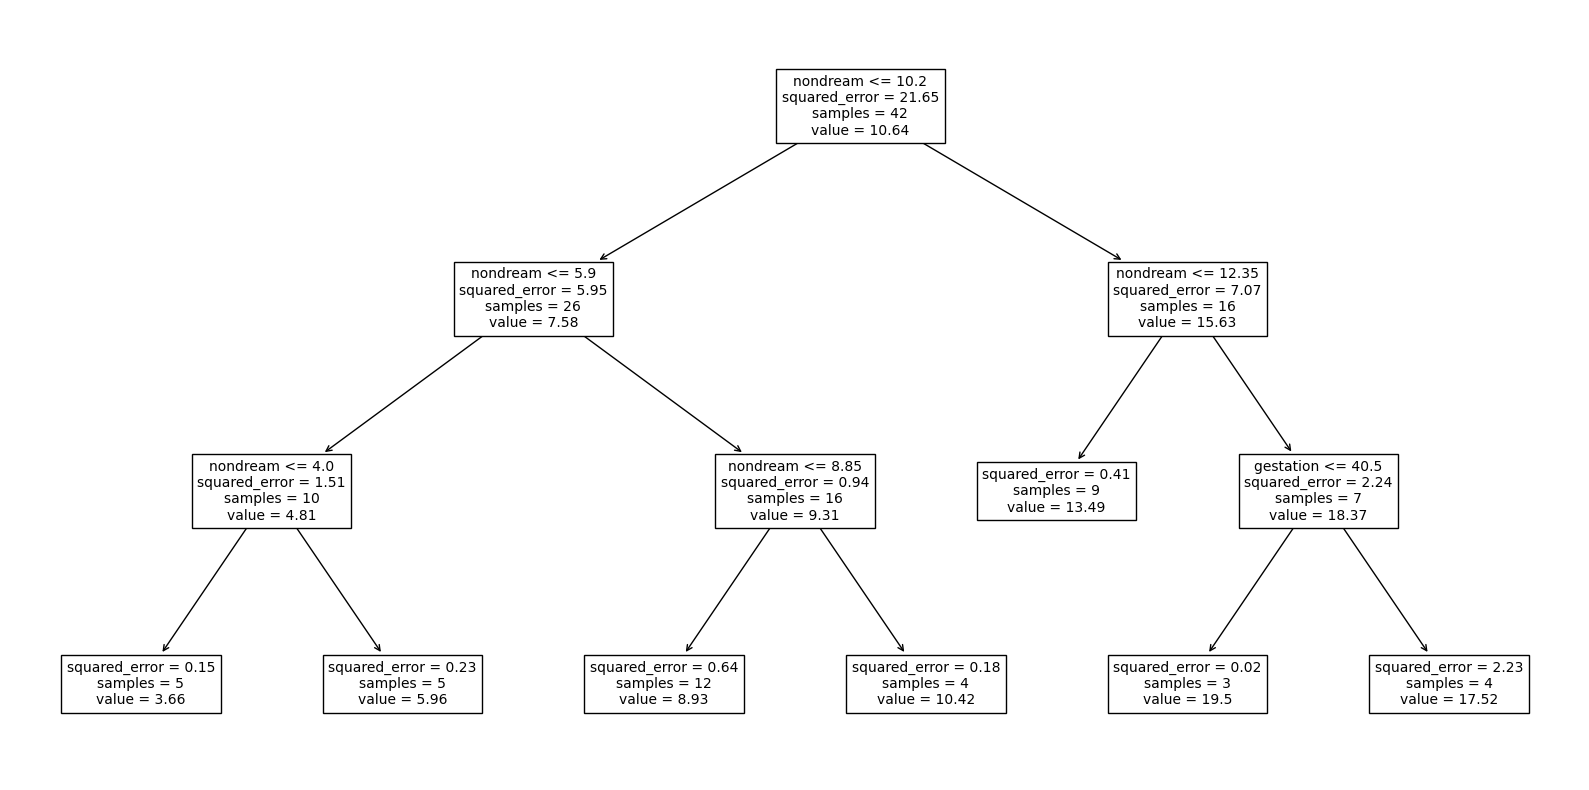

In [13]:
fig, ax = plt.subplots(figsize=(16, 8))
plot_tree(f_bonus, filled=False, feature_names=list(X.columns), fontsize=10, precision=2, ax=ax)
plt.tight_layout()
plt.show()


### 1.2 Interpret: what drives sleep duration in mammals?
The most important split is by `nondream`, i.e. hours per day spent asleep but not dreaming. That is a rather tautological predictor: mammals sleep longer when their non-dreaming sleep is longer. Hm.

For those species with more than 10.2 hours non-dream sleep per day, another split is made between more (or less) than 12 hours of non-dream sleep.

For the species sleeping less than 10.2 hours, the next split is by `exposure`, which quantifies whether a species is exposed to the elements (wind, rain, frost) during sleeping: if not (`exposure <= 4`), they sleep shortest.

The next splits are less worth going into, as the number of cases is getting fewer and fewer.

## 2 Exercise: Using random forest
There are several packages implementing the random forest algorithm. Please use **sklearn**'s `RandomForestRegressor`: it is the fastest and in several respects the "best" implementation (e.g. it offers the computation of standard errors for a prediction).

### 2.1 Fit

In [14]:
model = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=40)
model.fit(X, y)

sample_size_percentage = X.shape[0]
num_vars = X.shape[1]
Minimum_Sample_leaf = model.min_samples_leaf
split_rule = model.criterion


# Accessing model information
print("Number of trees                        :", model.n_estimators)
print("Number of independent variables        :", num_vars)
print("Max features considered at each split  :", model.max_features)
print("Minimum Sample leaf                    :", Minimum_Sample_leaf)
print("Split criterion                        :", split_rule)
print("R squared (OOB)                        :", model.oob_score_)  # R-squared value on Out-of-bag data


Number of trees                        : 500
Number of independent variables        : 9
Max features considered at each split  : 1.0
Minimum Sample leaf                    : 1
Split criterion                        : squared_error
R squared (OOB)                        : 0.9447513020429354


### 2.2 Importance
Plot and print importance. First sort decreasingly. Note that you have to re-fit the model with an additional argument first.

In [15]:
# Get numerical feature importances
importances = list(model.feature_importances_)
feature_list = list(X.columns)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(feature_list, importances)]


# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)


# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: nondream             Importance: 0.94855
Variable: danger               Importance: 0.01511
Variable: dream                Importance: 0.00931
Variable: gestation            Importance: 0.00669
Variable: predation            Importance: 0.00557
Variable: brain                Importance: 0.00453
Variable: exposure             Importance: 0.00363
Variable: body                 Importance: 0.00341
Variable: lifespan             Importance: 0.00319


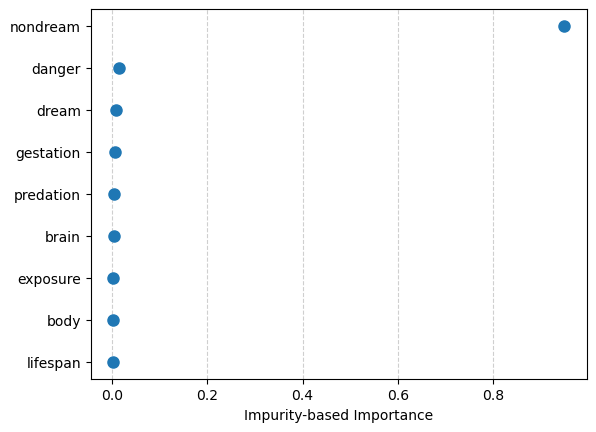

In [16]:
importances = model.feature_importances_

sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]

plt.plot(sorted_importances, range(len(sorted_importances)), 'o', markersize=8)
plt.yticks(range(len(sorted_importances)), X.columns[sorted_indices])
plt.xlabel("Impurity-based Importance")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.gca().invert_yaxis()
plt.show()


## 3 Exercise: Boosting
There are several boosting implementations. The one that currently is most successful in machine-learning competitions is "XGboost".
### 3.1 Fit XGboost

In [18]:
X = mammalsleep.drop("sleep", axis=1)
y = mammalsleep["sleep"]

# Create DMatrix for input to XGBoost
data_matrix = xgb.DMatrix(X, label=y)

# Set parameters for XGBoost model
params = {
    'max_depth': 2,
    'eta': 0.7,
    'nthread': 2,
    'objective': 'reg:squarederror'
}

# Train the XGBoost model
fm_xg = xgb.train(params=params, dtrain=data_matrix, num_boost_round=11, verbose_eval=True)

y_pred = fm_xg.predict(xgb.DMatrix(X)) 
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"RMSE = {rmse:.4f}")

# Retrieve feature importance scores
feature_importance = fm_xg.get_score(importance_type='weight')
print("Feature Importance:")
print(feature_importance)

# Retrieve and display the trees built during training (optional)
trees = fm_xg.get_dump()
for i, tree in enumerate(trees):
    print(f"Tree {i}:\n{tree}")


RMSE = 0.1894
Feature Importance:
{'body': 3.0, 'brain': 3.0, 'nondream': 10.0, 'dream': 4.0, 'lifespan': 1.0, 'gestation': 4.0, 'predation': 3.0, 'danger': 1.0}
Tree 0:
0:[nondream<10.3999996] yes=1,no=2,missing=2
	1:[nondream<6.0999999] yes=3,no=4,missing=4
		3:leaf=-3.71181822
		4:leaf=-0.880588472
	2:[nondream<12.8000002] yes=5,no=6,missing=6
		5:leaf=1.79299963
		6:leaf=4.73374987

Tree 1:
0:[nondream<9.5] yes=1,no=2,missing=2
	1:[nondream<4.69999981] yes=3,no=4,missing=4
		3:leaf=-1.90810621
		4:leaf=-0.543962419
	2:[danger<2] yes=5,no=6,missing=6
		5:leaf=2.0981102
		6:leaf=0.603656054

Tree 2:
0:[nondream<6.5999999] yes=1,no=2,missing=2
	1:[body<0.785000026] yes=3,no=4,missing=4
		3:leaf=-0.141256228
		4:leaf=-0.652501881
	2:[dream<3.9000001] yes=5,no=6,missing=6
		5:leaf=0.167880744
		6:leaf=1.0580554

Tree 3:
0:[nondream<15.1999998] yes=1,no=2,missing=2
	1:[gestation<19] yes=3,no=4,missing=4
		3:leaf=0.478752851
		4:leaf=-0.136402205
	2:leaf=0.748384595

Tree 4:
0:[predation<

<Axes: >

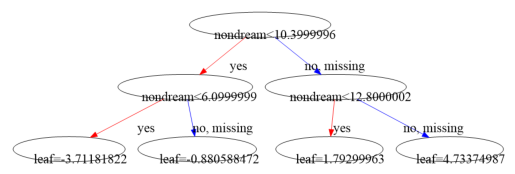

In [19]:
tree_index = 0

# Plot the specified tree
xgb.plot_tree(fm_xg, num_trees=tree_index)


In [22]:
# Extract RMSE for each round
results = fm_xg.get_score(importance_type='weight')
rounds_rmse = []

for i, (metric_name, value) in enumerate(results.items()):
    round_num = i + 1
    rmse = np.sqrt(float(value))
    rounds_rmse.append(rmse)
    print(f"Round {round_num}: RMSE = {rmse:.4f}")

Round 1: RMSE = 1.7321
Round 2: RMSE = 1.7321
Round 3: RMSE = 3.1623
Round 4: RMSE = 2.0000
Round 5: RMSE = 1.0000
Round 6: RMSE = 2.0000
Round 7: RMSE = 1.7321
Round 8: RMSE = 1.0000


### 3.2 Visualise importance

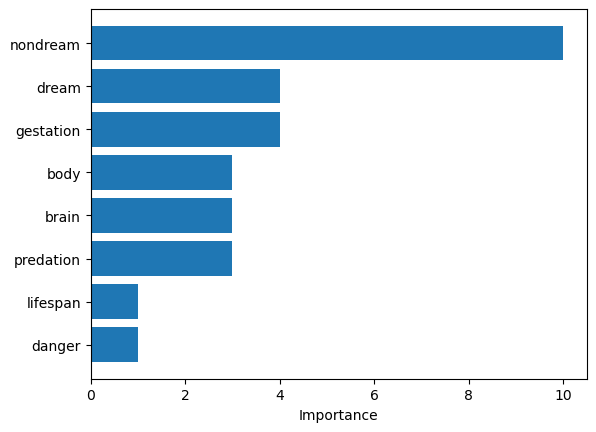

In [23]:
feature_names = list(X.columns)
importances = fm_xg.get_fscore()

importance_df = pd.DataFrame({'Feature': list(importances.keys()),'Importance': list(importances.values())})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()


RMSE = 0.0007


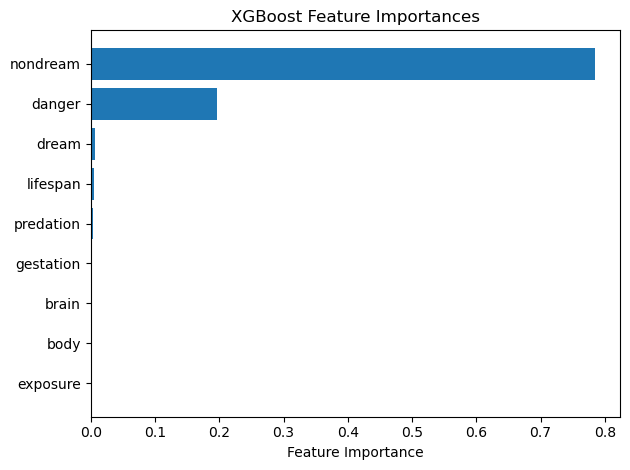

In [24]:
# Using XGBRegressor() : Sklearn API

XGB_reg = xgb.XGBRegressor(n_estimators=2000, learning_rate=0.1, nthread=2, objective="reg:squarederror") 
XGB_fit = XGB_reg.fit(X, y)

y_pred2 = XGB_fit.predict(X) 
rmse = np.sqrt(mean_squared_error(y, y_pred2))
print(f"RMSE = {rmse:.4f}")

# Get feature importances
importance = XGB_reg.feature_importances_

# Map feature importance values to corresponding feature names (if available)
feature_names = X.columns  # Assuming the features have column names
feature_importance_map = dict(zip(feature_names, importance))

# Sort feature importance in descending order
sorted_importance = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

# Extract feature names and importance values for plotting
features, importance_values = zip(*sorted_importance)

# Plotting feature importances
plt.barh(range(len(features)), importance_values, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.tight_layout()
plt.show()



## 4 Exercise: Trees vs line
Compare, for smooth relationship, LM, GAM, CART, RF and XGBOOST (`plus` GBR, BGR, ADA).

### 4.1 Fit only `nondream`

In [25]:
new_nondream = np.linspace(2, 18, num=101)

# Linear Regression
flm = LinearRegression()
flm.fit(mammalsleep[['nondream']], mammalsleep['sleep'])
lm_predictions = flm.predict(new_nondream.reshape(-1, 1))

# GAM using pygam
fgam = LinearGAM(s(0)).fit(mammalsleep[['nondream']], mammalsleep['sleep'])
gam_predictions = fgam.predict(new_nondream)

# Decision Tree (CART)
fr = DecisionTreeRegressor()
fr.fit(mammalsleep[['nondream']], mammalsleep['sleep'])
cart_predictions = fr.predict(new_nondream.reshape(-1, 1))

# Random Forest
frf = RandomForestRegressor()
frf.fit(mammalsleep.dropna()[['nondream']], mammalsleep.dropna()['sleep'])
rf_predictions = frf.predict(new_nondream.reshape(-1, 1))

# XGBoost 1
data_matrix = xgb.DMatrix(mammalsleep.dropna()[['nondream']].values.reshape(-1, 1), label=mammalsleep.dropna()['sleep'])
params = {'max_depth': 4,'eta': 1,'nthread': 2,'objective': 'reg:squarederror'}
fit_xg1 = xgb.train(params=params, dtrain=data_matrix, num_boost_round=10, verbose_eval=True) 
xg1_predictions = fit_xg1.predict(xgb.DMatrix(new_nondream.reshape(-1, 1)))

# XGBoost 2
fit_xg2 = xgb.XGBRegressor() #max_depth=4, eta=1, nthread=2, objective="reg:squarederror"
fit_xg2.fit(mammalsleep.dropna()[['nondream']], mammalsleep.dropna()['sleep'])
xg2_predictions = fit_xg2.predict(new_nondream.reshape(-1, 1))

### Bonus ###
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor

# Gradient Boosting Regression
GB_reg = GradientBoostingRegressor(random_state=1) 
GB_reg_model = GB_reg.fit(mammalsleep.dropna()[['nondream']], mammalsleep.dropna()['sleep'])
GB_reg_predictions = GB_reg_model.predict(new_nondream.reshape(-1, 1))

# using BaggingRegressor
Bagr_reg = BaggingRegressor(RandomForestRegressor(), random_state=5) 
Bagr_reg_model = Bagr_reg.fit(mammalsleep.dropna()[['nondream']], mammalsleep.dropna()['sleep'])
Bagr_reg_predictions = Bagr_reg_model.predict(new_nondream.reshape(-1, 1))

# using AdaBoostRegressor
Ada_reg = AdaBoostRegressor(RandomForestRegressor(), random_state=5) 
Ada_reg_model = Ada_reg.fit(mammalsleep.dropna()[['nondream']], mammalsleep.dropna()['sleep'])
Ada_reg_predictions = Ada_reg_model.predict(new_nondream.reshape(-1, 1))


print(fit_xg2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


### 4.2 Plot

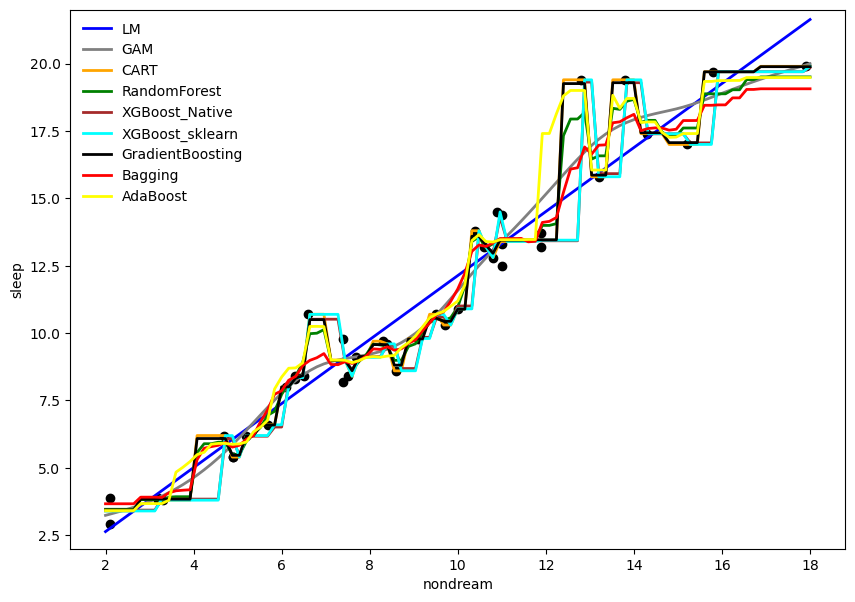

In [26]:
plt.figure(figsize=(10,7))
plt.scatter(mammalsleep[['nondream']], mammalsleep['sleep'], marker="o", color="black")
plt.plot(new_nondream, lm_predictions, label="LM", color="blue", linewidth=2)
plt.plot(new_nondream, gam_predictions, label="GAM", color="grey", linewidth=2)
plt.plot(new_nondream, cart_predictions, label="CART", color="orange", linewidth=2)
plt.plot(new_nondream, rf_predictions, label="RandomForest", color="green", linewidth=2)
plt.plot(new_nondream, xg1_predictions, label="XGBoost_Native", color="brown", linewidth=2)
plt.plot(new_nondream, xg2_predictions, label="XGBoost_sklearn", color="cyan", linewidth=2)
plt.plot(new_nondream, GB_reg_predictions, label="GradientBoosting", color="black", linewidth=2)
plt.plot(new_nondream, Bagr_reg_predictions, label="Bagging", color="red", linewidth=2)
plt.plot(new_nondream, Ada_reg_predictions, label="AdaBoost", color="yellow", linewidth=2)
plt.ylim(2, 22)
plt.xlabel("nondream")
plt.ylabel("sleep")
plt.legend(loc="upper left", frameon=False, fontsize=10)
plt.show()


Noteworthy aspects: 

  * recursive partitiong only fits very few steps
  * CART and XGboost yield very similar lines, with both even overfitting (with these settings)
  * only the linear model and GAM can extrapolate the trend in the data; all tree-based approaches end on the highest/lowest group value
  
This tells us nothing about the predictive performance; for that we need cross-validations.

### 4.3 Bonus: Tuning the model
R's **caret** offers a standardised way to call many different models (using `train`). Also, 
it allows specification of parameters to be changed and optimised. The target is best performance in cross-validation. It takes some time to get used to the strict rules necessary to run these functions.

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up parameter grid
param_grid = {
    'max_depth': range(2, 5, 1),           # 10
    'gamma': [0.1, 0.2, 0.3],              # 0.4, 0.5
    'n_estimators': range(100, 300, 100),  # 600
    'learning_rate': [0.1, 0.01, 0.05]
}

# Create the model
model = xgb.XGBRegressor(objective="reg:squarederror", nthread=4, subsample=1, colsample_bytree=1, seed=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2') #['neg_mean_squared_error', 'r2']
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}


## 5 Exercise: Putting the “Classification” into CARTs
In this classical data set, we seek to identify the species of Iris from the length of its sepals and petals. There are three
species of Iris in this data set, so it is a classification into three groups, with four predictors (sepal and petal width and
length, respectively). <br>

This very short exercise is just to demonstrate that the above methods can be used for classification, not “only” for
regression.

1. Plot the iris lengths and widths using pairs, but with a different colour for each of the three species.
2. Split the data into a 70% training and 30% test data set randomly.
3. Fit a random forest model (using ranger’s ranger) with Species as response.
4. Predict with the fitted model to the test data. Construct a confusion matrix and compute its various indices
(such as specificity, sensitivity, kappa, F1-score and so forth). One (of many) options is to use caret’s
confusionMatrix for that.
5. Interpret your finding: are sepal/petal width/length useful for distinguishing between Iris species?

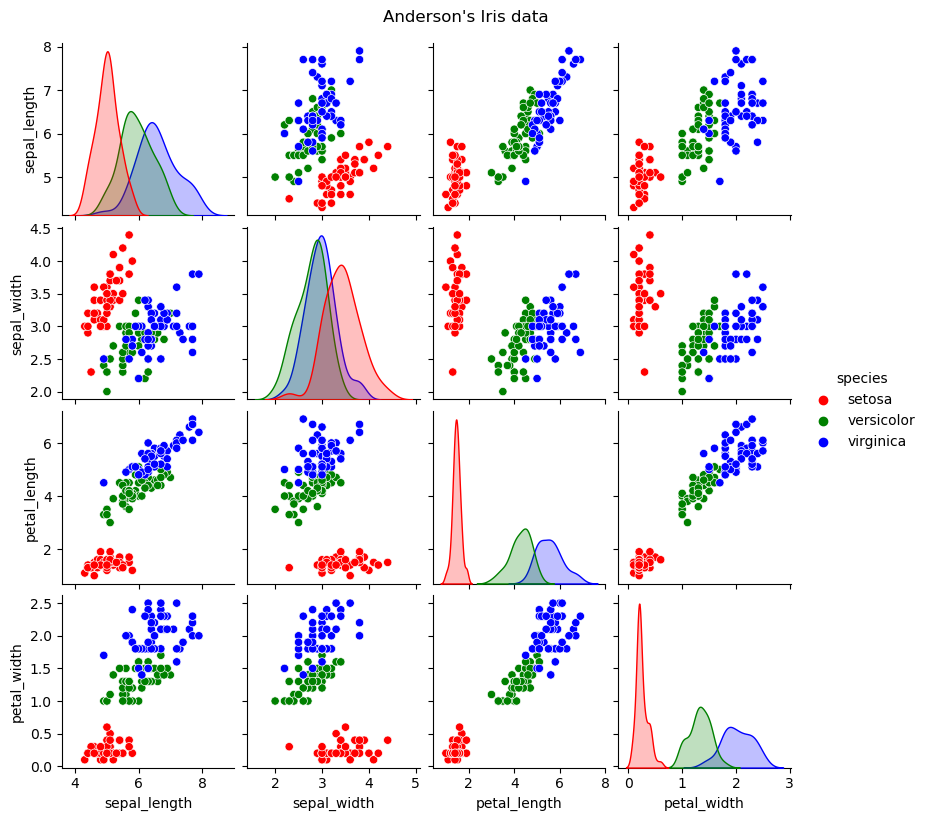

In [28]:
# data(iris)
from sklearn.datasets import load_iris
import seaborn as sns

# Load the Iris dataset
iris = load_iris()
iris_df = sns.load_dataset('iris')  # Load Iris dataset as a DataFrame using seaborn

# Create a pairplot with colored markers based on species
sns.pairplot(iris_df, hue='species', palette={"setosa": "red", "versicolor": "green", "virginica": "blue"},
              height=2) #markers=["o", "s", "D"],
plt.suptitle("Anderson's Iris data", y=1.02) 
plt.show()

In [29]:
X = iris_df.drop("species", axis=1)
y = iris_df["species"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, shuffle=True, random_state=4)

Dt = DecisionTreeClassifier()
Dt_model = Dt.fit(X_train, y_train)
Dt_pred = Dt_model.predict(X_test)

print(confusion_matrix(y_test, Dt_pred))
print('Accuracy score is : ', accuracy_score(y_test, Dt_pred))


[[21  0  0]
 [ 0  9  1]
 [ 0  0 14]]
Accuracy score is :  0.9777777777777777


In [30]:
from sklearn.svm import SVC

model = SVC(C=1, kernel='rbf', tol=0.001)
model.fit(X_train, y_train)

y_preds = model.predict(X_test)

print(confusion_matrix(y_test, y_preds))
print('\n')
print(classification_report(y_test, y_preds))
print('\n')
print('Accuracy score is : ', accuracy_score(y_test, y_preds))

[[21  0  0]
 [ 0  9  1]
 [ 0  0 14]]


              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        21
  versicolor       1.00      0.90      0.95        10
   virginica       0.93      1.00      0.97        14

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.97        45
weighted avg       0.98      0.98      0.98        45



Accuracy score is :  0.9777777777777777


In [ ]:
# xgb.XGBClassifier(n_estimators=200, max_depth=2, learning_rate=1, objective='multi:softprob')
# RandomForestClassifier()
# BaggingClassifier()
# ...all previous 

In [32]:
model= BaggingClassifier()


cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)
score = cross_val_score(model, X, y, scoring="accuracy", cv=cv, n_jobs=-1)

np.mean(score) # mean accuracy
#np.std(score) 


0.95

In [33]:
### HYPERPARAMETERS

# 1. Number of trees
res = {}
for i in [10,25,50,100,200]: #400,800 : number of decision trees
    model= BaggingClassifier(n_estimators=i)
    
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=0)
    res[f'{i}'] = cross_val_score(model, X, y, scoring="accuracy", cv=cv, n_jobs=-1)
    
res.values()

dict_values([array([0.96, 0.94, 0.96, 0.92, 0.98, 0.98]), array([0.96, 0.94, 0.96, 0.92, 0.96, 1.  ]), array([0.96, 0.96, 0.96, 0.92, 0.98, 1.  ]), array([0.96, 0.94, 0.94, 0.92, 0.98, 1.  ]), array([0.96, 0.94, 0.96, 0.92, 0.98, 1.  ])])

In [34]:
list(res.keys()) # lists the number of decision trees

['10', '25', '50', '100', '200']